In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorboard
from datetime import datetime

%matplotlib inline
# Restrict GPU memory consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

# Configure tensorboard
logdir = "U:/Coding/~Learning/Pd/logs/linear_regression/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

1 Physical GPUs, 1 Logical GPUs


In [12]:
data = tf.keras.utils.get_file('moore.csv', 'https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv')

# Load int the data
data = pd.read_csv(data, header=None).values

X = data[:,0].reshape(-1, 1) # make it a 2-d array of size N x D where D = 1
y = data[:,1]

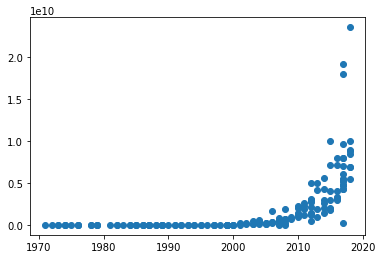

In [13]:
# Plot the data
plt.scatter(X, y)

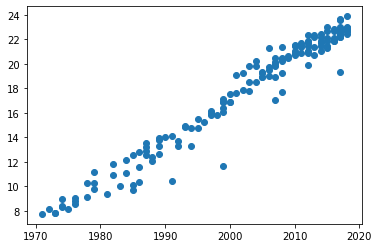

In [14]:
# Since we want a linear model, let's take the log
y = np.log(y)
plt.scatter(X, y)

In [15]:
# Let's also center the X data so the values are not too large
#We could scale it too but then we'd hagveto reverse the transormation later 
X = X - X.mean()

In [16]:
# Create our TF model
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(1)
])
#model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Dense(1, input_shape=(1,)))
model.compile(optimizer=tf.keras.optimizers.SGD(0.001, 0.9), loss='mse')

# learning rate scheduler
def schedule(epoch, lr):
    if epoch >= 50:
        return 0.0001
    return 0.001

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

# Train the model
training_history = model.fit(X, y, epochs=200, callbacks=[tensorboard_callback])

Epoch 1/200
6/6 [==============================] - 0s 33ms/step - loss: 421.6466
Epoch 2/200
6/6 [==============================] - 0s 1ms/step - loss: 353.7470
Epoch 3/200
6/6 [==============================] - 0s 1ms/step - loss: 284.7770
Epoch 4/200
6/6 [==============================] - 0s 1ms/step - loss: 279.7987
Epoch 5/200
6/6 [==============================] - 0s 1ms/step - loss: 186.8011
Epoch 6/200
6/6 [==============================] - 0s 1ms/step - loss: 159.8160
Epoch 7/200
6/6 [==============================] - 0s 1ms/step - loss: 201.4947
Epoch 8/200
6/6 [==============================] - 0s 1ms/step - loss: 180.1773
Epoch 9/200
6/6 [==============================] - 0s 1ms/step - loss: 175.4894
Epoch 10/200
6/6 [==============================] - 0s 1ms/step - loss: 245.3335
Epoch 11/200
6/6 [==============================] - 0s 1ms/step - loss: 251.3145
Epoch 12/200
6/6 [==============================] - 0s 1ms/step - loss: 126.8965
Epoch 13/200
6/6 [==================

In [17]:
# Get the slope of the line
# The slope of the line is related to the doubling rate of transistor coiunt
print(model.layers) # Note: there is only 1 layer, the input layer doesn't count
print(model.layers[0].get_weights())

[array([[0.34950283]], dtype=float32), array([17.798756], dtype=float32)]


In [18]:
# The slope of the line is:
a = model.layers[0].get_weights()[0][0,0]
a

0.34950283

Our original model for exponential growth is:

$$ C = A_0 r^t $$

Where $ C $ is transistor the count and $ t $ is the year.

$ r $ is the rate of growth. For example, when $ t $ goes from 1 to 2, $ C $ increases by a factor of $ r $. When $ t $ goes from 2 to 3, $ C $ increases by a factor of $ r $ again.

When we take the log of both sides, we get:

$$ \log C = \log r * t + \log A_0 $$

This is our linear equation:

$$ \hat{y} = ax + b $$

Where:

$$ \hat{y} = \log C $$
$$ a = \log r $$
$$ x = t $$
$$ b = \log A_0 $$

We are interested in $ r $, because that's the rate of growth. Given our regression weights, we know that:

$$ a = 0.34188038 $$

so that:

$$ r = e^{0.34188038} = 1.4076 $$

To find the time it takes for transistor count to double, we simply need to find the amount of time it takes for $ C $ to increase to $ 2C $.

Let's call the original starting time $ t $, to correspond with the initial transistor count $ C $.

Let's call the end time $ t' $, to correspond with the final transistor count $ 2C $.

Then we also have:

$$ 2C = A_0 r ^ {t'} $$

Combine this with our original equation:

$$ C = A_0 r^t $$

We get (by dividing the 2 equations):

$$ 2C/C = (A_0 r ^ {t'}) / A_0 r^t $$

Which simplifies to:

$$ 2 = r^{(t' - t)} $$

Solve for $ t' - t $:

$$ t' - t = \frac{\log 2}{\log r} = \frac{\log2}{a}$$


Important note! We haven't specified what the starting time $ t $ actually is, and we don't have to since we just proved that this holds for any $ t $.

In [19]:
print('time to double transistor (Moore was right!): ', np.log(2) / a)

time to double transistor (Moore was right!):  1.9832376670411245


# Making Predictions

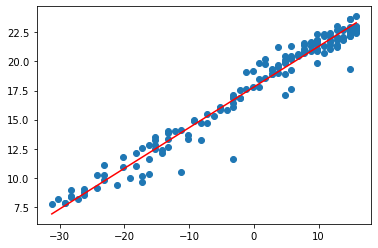

In [22]:
# make sure the line fits our data
Yhat = model.predict(X).flatten()
plt.scatter(X, y)
plt.plot(X, Yhat, color='red')

### Manual calculation

In [23]:
# Get the weights
w, b = model.layers[0].get_weights()

# Reshape X because we flattened it again earlier
X = X.reshape(-1, 1)

# (N x 1) x (1 x 1) + (1) --> (N x 1)
YhatMan = (X.dot(w) + b).flatten()

# Don't use == for floating points
np.allclose(Yhat, YhatMan)

True